<a href="https://colab.research.google.com/github/oxanaRC/CE902/blob/main/Random_forest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

08.08.21
Upload three csv files:
1. dataset for training and testing 
2. dataset for validation
3. dataset for records identification ('location key', 'postal code' and 'district) - this to be joined with data after predictions were done so the quality of predictions could be analysed by location.



In [1]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))


Saving train_and_test_data.csv to train_and_test_data.csv
Saving locations_categorical_features.csv to locations_categorical_features.csv
Saving validation_data.csv to validation_data.csv
User uploaded file "train_and_test_data.csv" with length 138911868 bytes
User uploaded file "locations_categorical_features.csv" with length 27802193 bytes
User uploaded file "validation_data.csv" with length 4745908 bytes


In [2]:
import pandas as pd
from pathlib import Path

In [3]:
df_location_categories = pd.read_csv("locations_categorical_features.csv") 
df_location_categories

,location_key,postcode,district
0,100000460_235813700_173697830,IP28 6QS,ST EDMUNDSBURY
1,100000900_306645770_193413260,PO2 9AE,PORTSMOUTH
2,100001709_306232250_192988720,PO2 8NT,PORTSMOUTH
3,100002450_241021470_178393000,IP33 3UF,ST EDMUNDSBURY
4,100002500_240933210_178314290,IP33 3UE,ST EDMUNDSBURY
...,...,...,...
562389,99996800_303056370_189735890,PO16 9PA,FAREHAM
562390,99998470_302856560_189531620,PO16 9UH,FAREHAM
562391,99998690_306575700_193341460,PO2 9BS,PORTSMOUTH
562392,9999870_270237390_170268490,SE21 7EU,SOUTHWARK


In [4]:
df_train_test_data = pd.read_csv("train_and_test_data.csv") 
df_train_test_data

,num_of_beds,price_paid,estate_type,property_type,num_of_sec_sch,score_disadv,closest_disadv_prct,closest_aver_attain_eng,closest_aver_attain_math,closest_sch_distance,hist_mnth,median_ppb_3mnths_ago,median_ppb_4mnths_ago,distances_Lond,distances_Manch,distances_Birming
0,1,100000.0,L,T,23.0,110.178111,96.0,0.5,0.9,0.671216,7,60250.00000,56187.50000,26510768000,718540000,11622296000
1,1,79500.0,L,S,24.0,78.275669,15.0,10.8,9.4,0.320619,23,79166.66667,79000.00000,26539970000,542647000,11902983000
2,1,128000.0,L,F,12.0,85.979811,20.0,11.5,9.8,0.584296,4,73416.66667,64341.66667,16016690000,25505656000,21724217000
3,1,170000.0,L,F,3.0,89.636307,13.0,9.7,8.3,0.452391,14,101666.66670,101666.66670,6296533000,26014878000,18039516000
4,1,33000.0,L,F,34.0,94.537513,63.0,8.1,7.7,0.458854,9,25562.50000,25000.00000,28437687000,4781898000,12633222000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1135504,47,79000.0,L,T,12.0,72.452903,39.0,8.5,7.5,1.542007,14,37625.00000,40499.37500,27236922000,1773271000,12075555000
1135505,48,53000.0,F,S,1.0,0.000000,0.0,0.0,0.0,0.000000,16,40000.00000,50500.00000,21104985000,21110074000,12654123000
1135506,55,70000.0,F,T,1.0,0.000000,0.0,0.0,0.0,0.000000,14,41333.33333,45416.66667,27804846000,6355589000,11793603000
1135507,81,95000.0,L,T,1.0,88.443148,25.0,9.7,7.7,2.462274,16,54000.00000,56650.00000,28051597900,2906478000,14022715000


In [5]:
df_validation_data = pd.read_csv("validation_data.csv") 
df_validation_data

,num_of_beds,price_paid,estate_type,property_type,num_of_sec_sch,score_disadv,closest_disadv_prct,closest_aver_attain_eng,closest_aver_attain_math,closest_sch_distance,hist_mnth,median_ppb_3mnths_ago,median_ppb_4mnths_ago,distances_Lond,distances_Manch,distances_Birming
0,1,314000.0,L,F,54.0,92.304597,36.0,11.4,9.6,0.543902,26,295000.00000,330000.00000,770794900,26771245000,16701868000
1,1,225000.0,F,T,35.0,78.178630,36.0,8.9,8.4,0.086689,26,113333.33330,119166.66670,2095469000,26684681000,17218624000
2,1,120000.0,L,F,11.0,67.921534,32.0,7.6,7.0,0.836103,26,92750.00000,80000.00000,10333301000,30370523000,19027695000
3,1,500000.0,L,F,60.0,104.272807,60.0,9.2,8.7,0.530036,26,302500.00000,279821.42860,502176000,26527685000,16536000000
4,1,52000.0,L,F,9.0,125.415966,39.0,9.0,7.6,0.658497,26,42000.00000,42908.33333,32407942000,6604266000,17029935000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38382,11,415000.0,F,D,12.0,84.705333,42.0,7.8,6.7,0.424683,26,48583.33333,57500.00000,25966523900,3773829000,12954650000
38383,11,900000.0,F,D,45.0,90.592648,53.0,10.7,8.1,0.935044,26,70250.00000,79583.33333,15885462000,11716322000,410900900
38384,12,840000.0,F,D,1.0,14.057832,10.0,10.6,10.5,4.594217,26,98833.33333,92500.00000,11001257000,15043775000,5857544000
38385,13,660000.0,F,D,42.0,86.608374,51.0,9.7,8.2,0.258647,26,40875.00000,59333.33333,16388710900,11226349000,417089900


In [6]:
estateTypes=df_train_test_data['estate_type'].unique()
estateTypes

array(['L', 'F'], dtype=object)

In [7]:
df_train_test_data['estate_type'] =df_train_test_data['estate_type'].map({'F':'2',
                             'L':'1'})
df_validation_data['estate_type'] =df_validation_data['estate_type'].map({'F':'2',
                             'L':'1'})


In [8]:
propertyTypes=df_train_test_data['property_type'].unique()
propertyTypes

array(['T', 'S', 'F', 'D'], dtype=object)

In [9]:
df_train_test_data['property_type'] =df_train_test_data['property_type'].map({'O':'5','D':'4','S':'3','T':'2','F':'1'})
df_validation_data['property_type'] =df_validation_data['property_type'].map({'O':'5','D':'4','S':'3','T':'2','F':'1'})

              

In [10]:
#shuffle the dataset
df_train_test_data = df_train_test_data.sample(frac = 1)
df_train_test_data

,num_of_beds,price_paid,estate_type,property_type,num_of_sec_sch,score_disadv,closest_disadv_prct,closest_aver_attain_eng,closest_aver_attain_math,closest_sch_distance,hist_mnth,median_ppb_3mnths_ago,median_ppb_4mnths_ago,distances_Lond,distances_Manch,distances_Birming
561147,3,157000.0,2,3,14.0,119.491715,22.0,10.2,8.8,1.379443,8,43416.66667,42333.33333,25003741000,13121198000,17733770000
605831,3,212500.0,2,3,10.0,76.456945,20.0,10.3,9.5,1.928316,3,65000.00000,65000.00000,25218948000,12566704000,17516767000
565917,3,260000.0,1,3,22.0,98.447276,85.0,1.6,1.8,0.643153,5,84154.00000,90437.50000,26174008900,717056000,11246793000
108186,2,180000.0,2,2,1.0,126.722792,24.0,9.7,9.1,0.719884,6,94575.00000,100000.00000,15116437000,24903931000,14045986000
1079070,4,540000.0,2,2,49.0,70.147628,22.0,13.1,10.9,1.024921,9,135000.00000,132875.00000,1661639000,26397298900,16838271000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193992,2,157000.0,2,2,4.0,109.923126,32.0,7.8,7.9,0.474519,2,61666.66667,61666.66667,19958914000,26557333000,16684449000
346339,3,575000.0,2,3,8.0,43.122470,13.0,11.8,11.4,0.970155,7,168000.00000,177750.00000,2312772000,25628807000,16311931000
554071,3,250000.0,2,4,2.0,26.126267,15.0,10.8,10.1,4.035321,10,74166.66667,101666.66670,31347237000,15062177000,22666697000
503040,3,500000.0,2,3,18.0,66.913437,12.0,10.5,10.9,0.774095,14,147500.00000,171077.08330,1991519000,26093268900,15622000000


In [11]:
dataset = df_train_test_data.values
dataset

array([[3, 157000.0, '2', ..., 25003741000, 13121198000, 17733770000],
       [3, 212500.0, '2', ..., 25218948000, 12566704000, 17516767000],
       [3, 260000.0, '1', ..., 26174008900, 717056000, 11246793000],
       ...,
       [3, 250000.0, '2', ..., 31347237000, 15062177000, 22666697000],
       [3, 500000.0, '2', ..., 1991519000, 26093268900, 15622000000],
       [3, 290000.0, '2', ..., 5037576900, 28520905000, 19666174000]],
      dtype=object)

In [12]:
X1 = dataset[:,0:15]
Y1 = dataset[:,15]
#all features

In [14]:
validation_dataset=df_validation_data.values
validation_dataset

array([[1, 314000.0, '1', ..., 770794900, 26771245000, 16701868000],
       [1, 225000.0, '2', ..., 2095469000, 26684681000, 17218624000],
       [1, 120000.0, '1', ..., 10333301000, 30370523000, 19027695000],
       ...,
       [12, 840000.0, '2', ..., 11001257000, 15043775000, 5857544000],
       [13, 660000.0, '2', ..., 16388710900, 11226349000, 417089900],
       [39, 95000.0, '1', ..., 27274740000, 2508229000, 11872660000]],
      dtype=object)

In [15]:
X_Validation=validation_dataset[:,0:15]
Y_Validation =validation_dataset[:,15]

In [16]:
from sklearn import preprocessing

In [17]:
min_max_scaler = preprocessing.MinMaxScaler()

In [18]:
X1_scale = min_max_scaler.fit_transform(X1)
X1_scale

array([[0.02150538, 0.01101747, 1.        , ..., 0.00860164, 0.50977689,
        0.29223759],
       [0.02150538, 0.01491221, 1.        , ..., 0.0139678 , 0.5141654 ,
        0.27984303],
       [0.02150538, 0.01824555, 0.        , ..., 0.01998994, 0.53364105,
        0.01496875],
       ...,
       [0.02150538, 0.01754379, 1.        , ..., 0.02264836, 0.63913374,
        0.33562415],
       [0.02150538, 0.03508765, 1.        , ..., 0.03908075, 0.04051067,
        0.58220131],
       [0.02150538, 0.02035081, 1.        , ..., 0.02639678, 0.10262601,
        0.63646608]])

In [19]:

print(min(Y1))
print(max(Y1))

67668000
37583409000


In [20]:
X_Validation_scale = min_max_scaler.fit_transform(X_Validation)
X_Validation_scale

array([[0.        , 0.03578103, 0.        , ..., 0.23558422, 0.01375593,
        0.60541714],
       [0.        , 0.02560849, 1.        , ..., 0.07561963, 0.04086589,
        0.60345382],
       [0.        , 0.01360719, 0.        , ..., 0.04590288, 0.20945628,
        0.68705081],
       ...,
       [0.28947368, 0.09590184, 1.        , ..., 0.05538695, 0.22312626,
        0.33943147],
       [0.31578947, 0.07532818, 1.        , ..., 0.03022256, 0.33338257,
        0.25285009],
       [1.        , 0.01074974, 0.        , ..., 0.02187658, 0.55616933,
        0.05511818]])

In [21]:
print(min(Y_Validation))
print(max(Y_Validation))

192705000
37105986000


In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X1_train, X1_test, Y1_train, Y1_test = train_test_split(X1_scale, Y1, test_size=0.1)

In [ ]:
print(X1_train.shape, X1_test.shape, Y1_train.shape, Y1_test.shape)

(1044204, 15) (116023, 15) (1044204,) (116023,)


In [ ]:
from sklearn.ensemble import RandomForestRegressor

In [ ]:
regr1 = RandomForestRegressor(max_depth=12, random_state=0)
regr1.fit(X1_train, Y1_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=12, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=0, verbose=0, warm_start=False)

In [ ]:
prediction1=regr1.predict(X1_test)
#print(prediction1)

In [ ]:
prediction_df1 = pd.DataFrame(min_max_scaler.inverse_transform(X1_test)) 
prediction_df1.columns =['num_of_beds', 'estate_type', 'property_type','num_of_sec_sch','score_disadv','closest_sch_distance', 'closest_disadv_prct',	'closest_aver_attain_eng',	'closest_aver_attain_math','median_ppb_3mnths_ago','median_ppb_4mnths_ago','hist_mnth',	'distances_Lond',	'distances_Manch',	'distances_Birming']
prediction_df1['Y1'] = Y1_test
prediction_df1['predictions1'] = prediction1
prediction_df1['error1']=prediction_df1['Y1']-prediction_df1['predictions1']
prediction_df1['sq_error1']=pow((prediction_df1['Y1']-prediction_df1['predictions1']),2)
prediction_df1['root_sq_error1']=pow(pow((prediction_df1['Y1']-prediction_df1['predictions1']),2),0.5)
prediction_df1['location_key']=(round((prediction_df1['distances_Lond']*0.01),0).astype(int)).astype(str) + '_' + (round((prediction_df1['distances_Manch']*0.01),0).astype(int)).astype(str)+ '_' + (round((prediction_df1['distances_Birming']*0.01),0).astype(int)).astype(str)
#prediction_df1['distances_Lond']=prediction_df1['distances_Lond'].astype(int)
#prediction_df1['distances_Manch']=prediction_df1['distances_Manch'].astype(int)
#prediction_df1['distances_Birming']=prediction_df1['distances_Birming'].astype(int)
#prediction_df1['location_key']=prediction_df1['distances_Lond'].astype(str) + '_' + prediction_df1['distances_Manch'].astype(str)+ '_' + prediction_df1['distances_Birming'].astype(str)
prediction_df1

,num_of_beds,estate_type,property_type,num_of_sec_sch,score_disadv,closest_sch_distance,closest_disadv_prct,closest_aver_attain_eng,closest_aver_attain_math,median_ppb_3mnths_ago,median_ppb_4mnths_ago,hist_mnth,distances_Lond,distances_Manch,distances_Birming,Y1,predictions1,error1,sq_error1,root_sq_error1,location_key
0,3.0,2.0,4.0,2.0,63.055406,1.532722,23.0,9.4,8.6,87500.00000,87500.00000,1.0,1.042553e+10,2.067096e+10,1.477499e+10,330000,308010.807435,21989.2,4.83525e+08,21989.2,104255260_206709580_147749890
1,2.0,1.0,1.0,8.0,59.113902,0.482658,16.0,10.9,11.6,58166.66667,58166.66667,3.0,1.735211e+10,9.668426e+09,7.820822e+09,145000,101061.924654,43938.1,1.93055e+09,43938.1,173521140_96684260_78208220
2,3.0,2.0,2.0,13.0,57.919396,0.606604,23.0,9.6,8.9,51000.00000,41666.66667,10.0,2.767452e+10,2.563677e+09,1.231750e+10,115000,107186.179095,7813.82,6.10558e+07,7813.82,276745210_25636770_123174990
3,2.0,2.0,4.0,9.0,39.083724,2.684117,19.0,9.6,8.7,50625.00000,54416.66667,14.0,2.959942e+10,3.631537e+09,1.453987e+10,162500,159891.784145,2608.22,6.80279e+06,2608.22,295994240_36315370_145398700
4,4.0,2.0,2.0,6.0,69.201245,1.504860,20.0,10.9,10.0,59375.00000,51875.00000,21.0,3.484958e+10,1.231331e+10,2.279696e+10,167500,213674.514573,-46174.5,2.13209e+09,46174.5,348495779_123133080_227969590
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116018,4.0,2.0,4.0,7.0,77.539402,0.670017,25.0,9.3,8.0,70666.66667,68666.66667,15.0,1.140299e+10,1.688775e+10,1.105633e+10,351000,318757.367008,32242.6,1.03959e+09,32242.6,114029900_168877510_110563290
116019,2.0,2.0,2.0,8.0,36.479408,0.729922,22.0,10.4,9.0,45125.00000,42000.00000,18.0,3.826237e+10,1.583956e+10,2.642790e+10,60000,82224.318993,-22224.3,4.9392e+08,22224.3,382623690_158395640_264279029
116020,4.0,2.0,4.0,11.0,47.304817,0.556424,5.0,13.7,14.7,119125.00000,113750.00000,8.0,1.525876e+10,3.041293e+10,1.924505e+10,398000,497455.029839,-99455,9.8913e+09,99455,152587560_304129300_192450480
116021,3.0,1.0,3.0,8.0,56.730018,2.811364,18.0,11.0,10.0,52991.66667,42000.00000,20.0,4.100055e+10,1.852694e+10,2.921703e+10,182000,143246.784105,38753.2,1.50181e+09,38753.2,410005490_185269430_292170300


In [ ]:
data_for_prediction_analysis = pd.merge(prediction_df1, data_for_prediction_analysis, how="left", on="location_key")
data_for_prediction_analysis['postcode_area']=data_for_prediction_analysis['postcode'].str.split(' ').str[0]
data_for_prediction_analysis

,num_of_beds,estate_type,property_type,num_of_sec_sch,score_disadv,closest_sch_distance,closest_disadv_prct,closest_aver_attain_eng,closest_aver_attain_math,median_ppb_3mnths_ago,median_ppb_4mnths_ago,hist_mnth,distances_Lond,distances_Manch,distances_Birming,Y1,predictions1,error1,sq_error1,root_sq_error1,location_key,postcode,district,postcode_area
0,3.0,2.0,4.0,2.0,63.055406,1.532722,23.0,9.4,8.6,87500.00000,87500.00000,1.0,1.042553e+10,2.067096e+10,1.477499e+10,330000,308010.807435,21989.2,4.83525e+08,21989.2,104255260_206709580_147749890,CB6 1BU,EAST CAMBRIDGESHIRE,CB6
1,2.0,1.0,1.0,8.0,59.113902,0.482658,16.0,10.9,11.6,58166.66667,58166.66667,3.0,1.735211e+10,9.668426e+09,7.820822e+09,145000,101061.924654,43938.1,1.93055e+09,43938.1,173521140_96684260_78208220,NG4 3GA,GEDLING,NG4
2,3.0,2.0,2.0,13.0,57.919396,0.606604,23.0,9.6,8.9,51000.00000,41666.66667,10.0,2.767452e+10,2.563677e+09,1.231750e+10,115000,107186.179095,7813.82,6.10558e+07,7813.82,276745210_25636770_123174990,WN4 8BY,WIGAN,WN4
3,2.0,2.0,4.0,9.0,39.083724,2.684117,19.0,9.6,8.7,50625.00000,54416.66667,14.0,2.959942e+10,3.631537e+09,1.453987e+10,162500,159891.784145,2608.22,6.80279e+06,2608.22,295994240_36315370_145398700,PR5 8HJ,CHORLEY,PR5
4,4.0,2.0,2.0,6.0,69.201245,1.504860,20.0,10.9,10.0,59375.00000,51875.00000,21.0,3.484958e+10,1.231331e+10,2.279696e+10,167500,213674.514573,-46174.5,2.13209e+09,46174.5,348495779_123133080_227969590,DL2 2JS,DARLINGTON,DL2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116018,4.0,2.0,4.0,7.0,77.539402,0.670017,25.0,9.3,8.0,70666.66667,68666.66667,15.0,1.140299e+10,1.688775e+10,1.105633e+10,351000,318757.367008,32242.6,1.03959e+09,32242.6,114029900_168877510_110563290,PE7 8EB,CITY OF PETERBOROUGH,PE7
116019,2.0,2.0,2.0,8.0,36.479408,0.729922,22.0,10.4,9.0,45125.00000,42000.00000,18.0,3.826237e+10,1.583956e+10,2.642790e+10,60000,82224.318993,-22224.3,4.9392e+08,22224.3,382623690_158395640_264279029,DH3 3JG,COUNTY DURHAM,DH3
116020,4.0,2.0,4.0,11.0,47.304817,0.556424,5.0,13.7,14.7,119125.00000,113750.00000,8.0,1.525876e+10,3.041293e+10,1.924505e+10,398000,497455.029839,-99455,9.8913e+09,99455,152587560_304129300_192450480,BH18 8NR,POOLE,BH18
116021,3.0,1.0,3.0,8.0,56.730018,2.811364,18.0,11.0,10.0,52991.66667,42000.00000,20.0,4.100055e+10,1.852694e+10,2.921703e+10,182000,143246.784105,38753.2,1.50181e+09,38753.2,410005490_185269430_292170300,NE23 3FY,NORTHUMBERLAND,NE23


In [ ]:
#check NA in data_for_prediction_analysis
data_for_prediction_analysis_na=data_for_prediction_analysis[(data_for_prediction_analysis['postcode'].isnull())]
data_for_prediction_analysis_na

,num_of_beds,estate_type,property_type,num_of_sec_sch,score_disadv,closest_sch_distance,closest_disadv_prct,closest_aver_attain_eng,closest_aver_attain_math,median_ppb_3mnths_ago,median_ppb_4mnths_ago,hist_mnth,distances_Lond,distances_Manch,distances_Birming,Y1,predictions1,error1,sq_error1,root_sq_error1,location_key,postcode,district,postcode_area


In [ ]:
from google.colab import files
with open('test data predictions.csv', 'w') as f:
  #f.write('some content')
  data_for_prediction_analysis.to_csv('test data predictions.csv', index=False)
files.download('test data predictions.csv')  

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
root_mse1=pow(prediction_df1['sq_error1'].sum()/prediction_df1['sq_error1'].count(),0.5)
root_mse1

69174.57158237182

In [ ]:
#considering good prediction where error 10% or less
prediction_df1['error_perc']=100*prediction_df1['root_sq_error1']/prediction_df1['Y1']
good_prediction_10pc_df1 =prediction_df1[(prediction_df1['error_perc'] <=10) ] 
#good_prediction_10pc_df1
within_10pc_error1=100*good_prediction_10pc_df1.shape[0]/prediction_df1.shape[0]
print('Predictions where error is 10% or less :' + str(within_10pc_error1) + ' %')
#considering good prediction where error 15% or less
good_prediction_15pc_df1 =prediction_df1[(prediction_df1['error_perc'] <=15) ] 
#considering predictions where error 20% or less
prediction_20pc_df1 =prediction_df1[(prediction_df1['error_perc'] <=20) ] 
#considering predictions where error 50% or more
prediction_over50pc_df1 =prediction_df1[(prediction_df1['error_perc'] >=50) ] 
#good_prediction_15pc_df1
within_15pc_error1=100*good_prediction_15pc_df1.shape[0]/prediction_df1.shape[0]
print('Predictions where error is 15% or less :' + str(within_15pc_error1) + ' %')
#prediction_20pc_df1
within_20pc_error1=100*prediction_20pc_df1.shape[0]/prediction_df1.shape[0]
print('Predictions where error is 20% or less :' + str(within_20pc_error1) + ' %')
#prediction_50pc_df1
within_50pc_error1=100*prediction_over50pc_df1.shape[0]/prediction_df1.shape[0]
print('Predictions where error is 50% or more :' + str(within_50pc_error1) + ' %')

Predictions where error is 10% or less :37.73820707963076 %
Predictions where error is 15% or less :53.274781724313286 %
Predictions where error is 20% or less :65.62233350283995 %
Predictions where error is 50% or more :5.743688751368263 %


In [ ]:
#Looking at the instances where prediction error is very high (50% and over)
prediction_over50pc_df1

,num_of_beds,estate_type,property_type,num_of_sec_sch,score_disadv,closest_sch_distance,closest_disadv_prct,closest_aver_attain_eng,closest_aver_attain_math,median_ppb_3mnths_ago,median_ppb_4mnths_ago,hist_mnth,distances_Lond,distances_Manch,distances_Birming,Y1,predictions1,error1,sq_error1,root_sq_error1,location_key,error_perc
9,3.0,2.0,2.0,1.0,126.011623,0.521234,23.0,8.3,8.5,76333.33333,86250.00000,25.0,2.867933e+10,3.048528e+10,2.274860e+10,128000,198235.508435,-70235.5,4.93303e+09,70235.5,286793270_304852830_227486050,54.8715
15,4.0,2.0,4.0,1.0,0.000000,0.000000,0.0,0.0,0.0,46666.66667,39312.50000,7.0,2.715212e+10,2.236292e+10,1.662762e+10,132000,227852.224798,-95852.2,9.18765e+09,95852.2,271521210_223629150_166276250,72.6153
24,2.0,1.0,1.0,12.0,127.509495,0.954952,79.0,8.6,7.5,44000.00000,45041.66667,7.0,3.993140e+10,1.711013e+10,2.788541e+10,48000,76502.133704,-28502.1,8.12372e+08,28502.1,399313990_171101320_278854080,59.3794
32,4.0,2.0,3.0,15.0,71.051250,0.876939,24.0,9.3,8.7,50500.00000,50416.66667,18.0,4.007732e+10,1.768663e+10,2.832303e+10,385000,189796.431012,195204,3.81044e+10,195204,400773190_176866320_283230260,50.7022
50,3.0,2.0,2.0,16.0,108.095744,0.623364,31.0,9.7,9.4,40700.00000,40700.00000,1.0,3.466778e+10,1.362792e+10,2.351229e+10,66000,101371.571381,-35371.6,1.25115e+09,35371.6,346677830_136279150_235122930,53.5933
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115978,2.0,1.0,1.0,9.0,66.423220,1.605011,15.0,11.6,10.3,102437.50000,81250.00000,16.0,4.012474e+10,1.813251e+10,2.863384e+10,102000,153616.620000,-51616.6,2.66428e+09,51616.6,401247379_181325120_286338400,50.6045
115981,2.0,1.0,1.0,16.0,88.823418,0.798192,56.0,8.3,7.4,57000.00000,48075.00000,9.0,3.951544e+10,1.685640e+10,2.756643e+10,51500,91649.367442,-40149.4,1.61197e+09,40149.4,395154410_168563970_275664320,77.9599
115996,3.0,1.0,2.0,2.0,51.726124,0.969630,20.0,9.2,10.0,110000.00000,108333.33330,6.0,6.919652e+09,1.994801e+10,1.160288e+10,121000,262968.512246,-141969,2.01551e+10,141969,69196520_199480120_116028780,117.329
115998,3.0,1.0,1.0,13.0,58.422373,1.970349,39.0,8.2,7.4,85000.00000,78541.66667,20.0,1.090950e+10,2.937104e+10,1.801054e+10,86000,180821.544671,-94821.5,8.99113e+09,94821.5,109094969_293710440_180105400,110.258


In [ ]:
import matplotlib.pyplot as plt

In [ ]:
import numpy as np

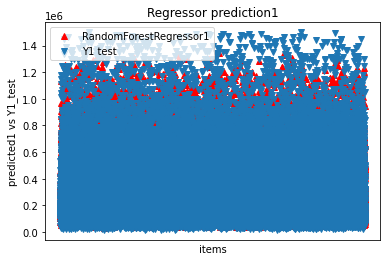

In [ ]:
plt.figure()
plt.plot(prediction1, 'r^', label='RandomForestRegressor1')
plt.plot(Y1_test, 'v', label='Y1 test')
plt.tick_params(axis='x', which='both', bottom=False, top=False,
                labelbottom=False)
plt.ylabel('predicted1 vs Y1_test')
plt.xlabel('items')
plt.legend(loc="best")
plt.title('Regressor prediction1')

plt.show()

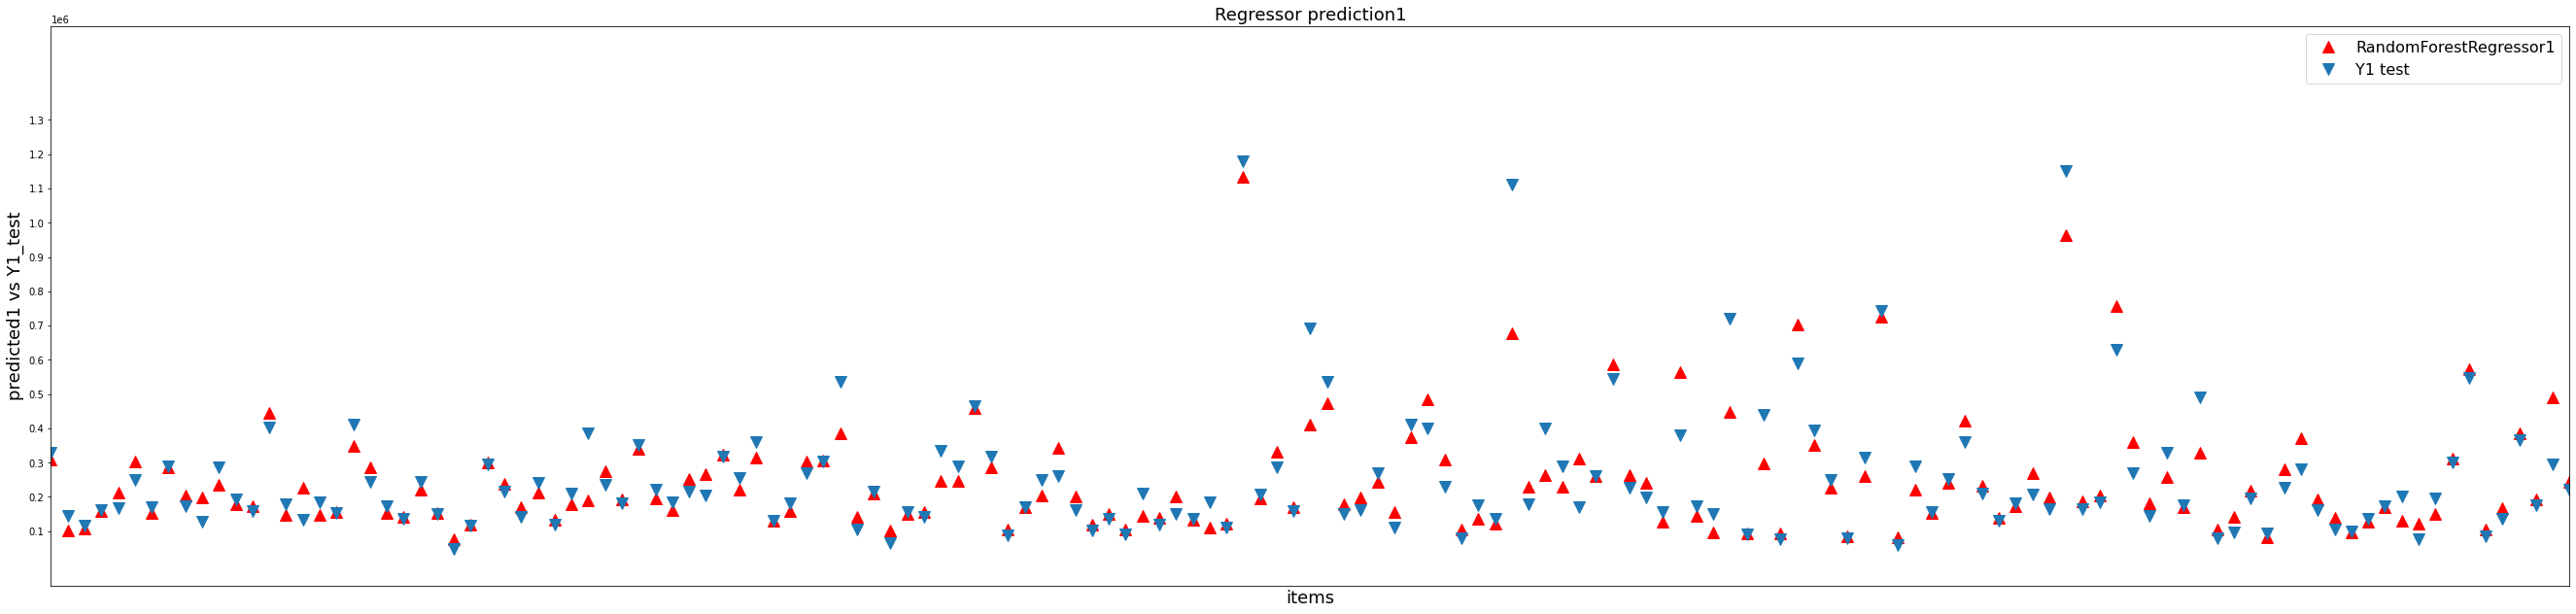

In [ ]:
a= plt.figure()
axes= a.add_axes([0,0,6,2])#sequence of [left, bottom, width, height] quantities.
#axes= a.add_axes([0.2,0.2,8,8])
# adding axes
#x= np.arange(0,11)
#axes.plot(prediction, marker='*')
y = np.array([100000, 200000, 300000, 400000, 500000, 600000,700000,800000, 900000, 1000000,1100000,1200000, 1300000,1400000])
plt.yticks(np.arange(y.min(), y.max(), 100000))

axes.plot(prediction1, 'r^', label='RandomForestRegressor1',markersize=12)
axes.plot(Y1_test, 'v', label='Y1 test',markersize=12)
axes.set_xlim([0,150])
plt.tick_params(axis='x', which='both', bottom=False, top=False,
                labelbottom=False)
plt.ylabel('predicted1 vs Y1_test', fontsize=18)
plt.xlabel('items', fontsize=18)
plt.legend(loc="best",prop={'size': 16})
plt.title('Regressor prediction1', fontsize=18)

plt.show()

In [ ]:
from sklearn import metrics
from sklearn.metrics import mean_squared_error

In [ ]:
mean_squared_error1=metrics.mean_squared_error(prediction1,Y1_test)
mean_squared_error1
root_mse1_2=pow(mean_squared_error1,0.5)
root_mse1_2

69174.57158237146

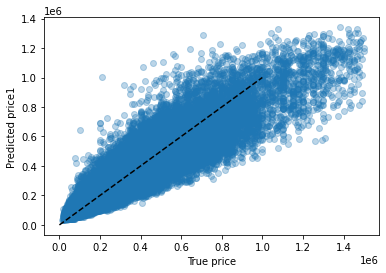

In [ ]:
plt.scatter(Y1_test,prediction1,alpha=0.3)
plt.plot([0,1000000],[0,1000000],'--k')
plt.axis('tight')
plt.xlabel('True price')
plt.ylabel('Predicted price1')
plt.show()
